### To Use KeyBERT as keyword extractor:

In [1]:
pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 5.3 MB/s 
     |████████████████████████████████| 232 kB 17.6 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
     |████████████████████████████████| 4.2 MB 59.6 MB/s 
     |████████████████████████████████| 1.2 MB 46.0 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
     |████████████████████████████████| 596 kB 27.8 MB/s 
     |████████████████████████████████| 6.6 MB 35.8 MB/s 
  Created wheel for keybert: filename=keybert-0.5.1-py3-none-any.whl size=21332 sha256=d506ead5e1296658b24476b7cd85ca4303fb13de3e2c78a3d84e8d0c9034ea6a
  Stored in directory: /root/.cache/pip/wheels/8e/95/c5/f5ceed2a9f9e80bc1a706a10a6fb03d726df7a3dd11800a58b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=d29e87ea1afc4b5bb5f9f74a72e9f9f74eb92ac458007cf825380745775cf017
  S

In [2]:
pip install keybert[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
from google.colab import drive
from keybert import KeyBERT
from wordcloud import WordCloud

In [5]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [6]:
plt.rcParams['figure.figsize'] = (16,12)

##############################################################################################################################################################################################################

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
df = pd.read_csv("../Phase1_dataCrawling/crawled_data/UTS.csv")

##############################################################################################################################################################################################################

In [9]:
df.shape

(3994, 17)

In [10]:
df.head()

,University,Abbreviation,Department,Course title,Unit,Professor,Objective,Prerequisite,Required Skills,Outcome,References,Scores,Description,Projects,University Homepage,Course Homepage,Professor Homepage
0,University of Technology Sydney,UTS,NaN,NaN,8,NaN,[],[],[],[],[],NaN,NaN,[],https://www.uts.edu.au/,https://handbook.uts.edu.au/subjects/999781.html,NaN
1,University of Technology Sydney,UTS,Health (Faculty),Exchange Subject 4,6,NaN,[],[],[],[],[],"Pass fail, no marks",urther information about this subject is avail...,[],https://www.uts.edu.au/,https://handbook.uts.edu.au/subjects/99884.html,NaN
2,University of Technology Sydney,UTS,Health (Faculty),Exchange Subject 3,6,NaN,[],[],[],[],[],"Pass fail, no marks",urther information about this subject is avail...,[],https://www.uts.edu.au/,https://handbook.uts.edu.au/subjects/99883.html,NaN
3,University of Technology Sydney,UTS,Health (Faculty),Exchange Subject 2,6,NaN,[],[],[],[],[],"Pass fail, no marks",urther information about this subject is avail...,[],https://www.uts.edu.au/,https://handbook.uts.edu.au/subjects/99882.html,NaN
4,University of Technology Sydney,UTS,Health (Faculty),Exchange Subject 1,6,NaN,[],[],[],[],[],"Pass fail, no marks",urther information about this subject is avail...,[],https://www.uts.edu.au/,https://handbook.uts.edu.au/subjects/99881.html,NaN


In [11]:
# Replacing empty strings with NaN
df = df.replace('[]', np.NaN)

## Data cleaning by dropping unuseful columns

In [12]:
def is_all_null(column):
    return df[column].isnull().all()

In [13]:
for column in df.columns:
    if is_all_null(column):
        df = df.drop(column, axis=1)
        print(f'Dropped column: {column}')

Dropped column: Professor
Dropped column: Required Skills
Dropped column: Professor Homepage


In [14]:
df.shape

(3994, 14)

In [15]:
df.isna().sum()

University                0
Abbreviation              0
Department              156
Course title            156
Unit                      0
Objective               800
Prerequisite           3189
Outcome                1757
References             2528
Scores                  185
Description             364
Projects               3593
University Homepage       0
Course Homepage           0
dtype: int64

## Preprocessing

In [16]:
porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')

In [17]:
feature_columns = [
    "Objective", 
    "Description", 
    "Outcome"
]

In [18]:
def listToString(stringList, separator):
    string = "" 
    for element in stringList: 
        string += (element + separator)
    string = string[:len(string) - len(separator)]  
    return string 

In [19]:
preprocessed_objectives = {}
preprocessed_descriptions = {}
preprocessed_outcomes = {}

In [20]:
for i, row in df.iterrows():
    if i % 500 == 0:
        print(f'Preprocessing sample {i}/{len(df)}')
    
    # Extracting words
    for feature in feature_columns:
        words = []
        preprocessedSentence = None
        if type(row[feature]) == str:
            words = re.split(r'\W+', row[feature])
            words = list(filter(lambda word: word != '', words))
         
        # Removing stopwords:
        for word in words:
            if word in stop_words:
                words.remove(word)
        # Stemming + lemmatizing:
        for indx in range(len(words)):
            words[indx] = porter.stem(words[indx])
            words[indx] = lemmatizer.lemmatize(words[indx])

        preprocessedSentence = listToString(words, ' ')
        if feature == 'Objective':
            preprocessed_objectives[i] = preprocessedSentence
        elif feature == 'Description':
            preprocessed_descriptions[i] = preprocessedSentence
        else:
            preprocessed_outcomes[i] = preprocessedSentence

Preprocessing sample 0/3994
Preprocessing sample 500/3994
Preprocessing sample 1000/3994
Preprocessing sample 1500/3994
Preprocessing sample 2000/3994
Preprocessing sample 2500/3994
Preprocessing sample 3000/3994
Preprocessing sample 3500/3994


### Extracting statistical information for each department

In [21]:
department_courses_count = df.groupby(by='Department', dropna=True)['Course title'].count().sort_values(ascending = False).to_dict()

<BarContainer object of 48 artists>

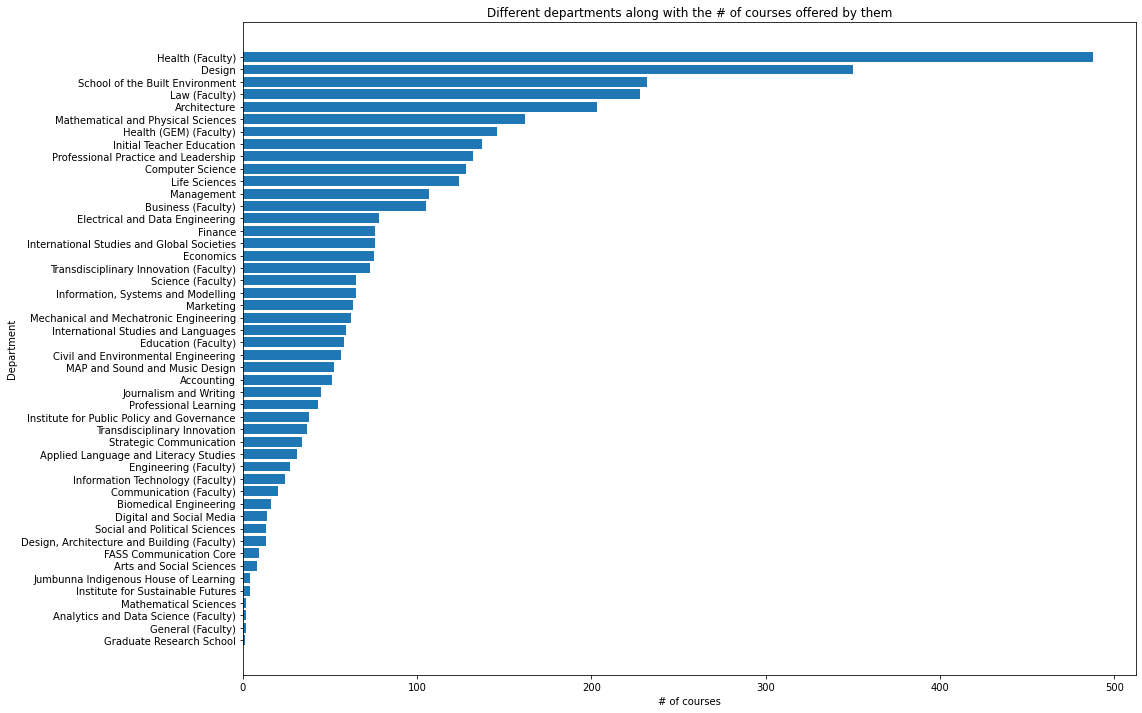

In [22]:
plt.title('Different departments along with the # of courses offered by them')
plt.xlabel('# of courses')
plt.ylabel('Department')

plt.barh(
    list(department_courses_count.keys())[::-1],
    list(department_courses_count.values())[::-1],
)

In [23]:
department_offered_units_avg =  df.groupby(
    by='Department', 
    dropna=True
)['Unit'].mean().to_dict()

In [24]:
department_offered_units_std =  df.groupby(
    by='Department', 
    dropna=True
)['Unit'].std().to_dict()

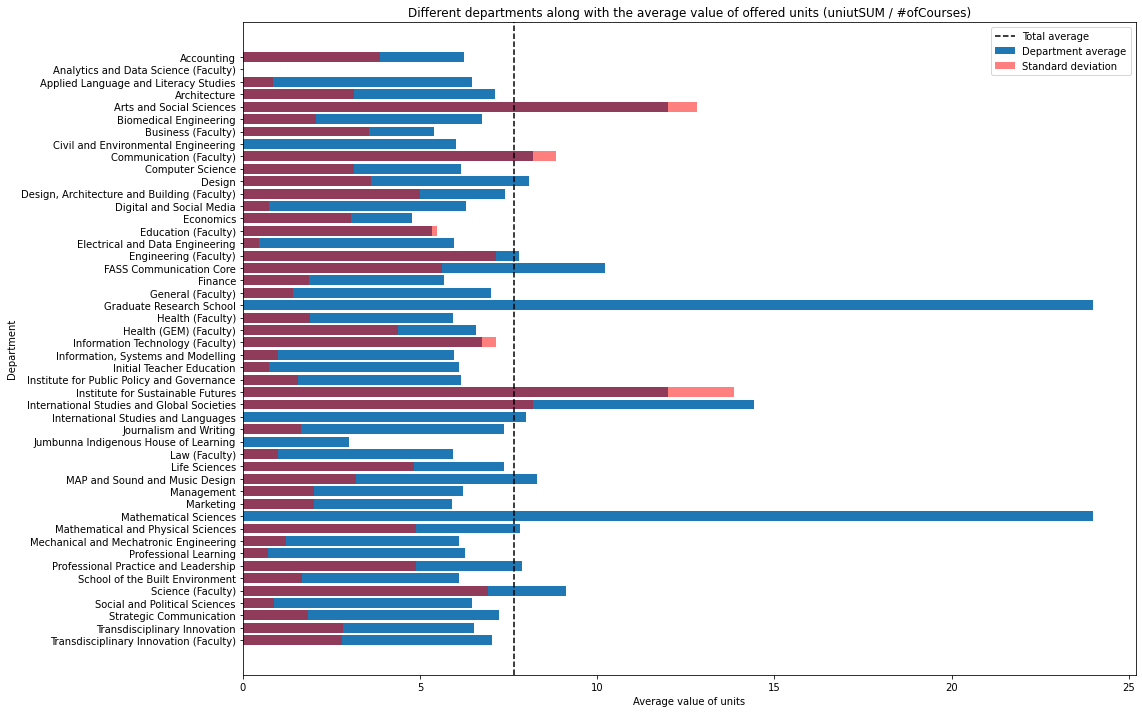

In [26]:
plt.title('Different departments along with the average value of offered units (uniutSUM / #ofCourses)')
plt.xlabel('Average value of units')
plt.ylabel('Department')

plt.barh(
    list(department_offered_units_avg.keys())[::-1],
    list(department_offered_units_avg.values())[::-1],
    label='Department average'
)

plt.barh(
    list(department_offered_units_std.keys())[::-1],
    list(department_offered_units_std.values())[::-1],
    alpha=0.5, 
    color='red',
    label='Standard deviation'
)

# plot the mean value of units for all
# departments
plt.axvline(
    np.mean(list(department_offered_units_avg.values())),
    label='Total average',
    color='black',
    linestyle='dashed'
)

plt.legend()

### Keywords Extraction Using KeyBERT

In [27]:
kw_model = KeyBERT()
keywordsInOutcomes = [None]*len(df)
keywordsInObjectives = [None]*len(df)
keywordsInDescriptions = [None]*len(df)
for i in range(len(df)):
    if i % 200 == 0:
      print('Keywords extracted for sample: ', i, '/', len(df))
    if len(preprocessed_outcomes[i]) > 0:
        keywordsInOutcomes[i] = kw_model.extract_keywords(preprocessed_outcomes[i], use_mmr=True, diversity=0.1)
    if len(preprocessed_objectives[i]) > 0:
        keywordsInObjectives[i] = kw_model.extract_keywords(preprocessed_objectives[i], use_mmr=True, diversity=0.1)
    if len(preprocessed_descriptions[i]) > 0:
        keywordsInDescriptions[i] = kw_model.extract_keywords(preprocessed_descriptions[i], use_mmr=True, diversity=0.1)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Keywords extracted for sample:  0 / 3994
Keywords extracted for sample:  200 / 3994
Keywords extracted for sample:  400 / 3994
Keywords extracted for sample:  600 / 3994
Keywords extracted for sample:  800 / 3994
Keywords extracted for sample:  1000 / 3994
Keywords extracted for sample:  1200 / 3994
Keywords extracted for sample:  1400 / 3994
Keywords extracted for sample:  1600 / 3994
Keywords extracted for sample:  1800 / 3994
Keywords extracted for sample:  2000 / 3994
Keywords extracted for sample:  2200 / 3994
Keywords extracted for sample:  2400 / 3994
Keywords extracted for sample:  2600 / 3994
Keywords extracted for sample:  2800 / 3994
Keywords extracted for sample:  3000 / 3994
Keywords extracted for sample:  3200 / 3994
Keywords extracted for sample:  3400 / 3994
Keywords extracted for sample:  3600 / 3994
Keywords extracted for sample:  3800 / 3994


In [31]:
keywords = [None]*len(df)
for i in range(len(keywords)):
    keywords[i] = []
    if keywordsInObjectives[i] is not None:
        for j in range(len(keywordsInObjectives[i])):
            keywords[i].append(keywordsInObjectives[i][j][0])
    elif keywordsInOutcomes[i] is not None:
        for j in range(len(keywordsInOutcomes[i])):
            keywords[i].append(keywordsInOutcomes[i][j][0])

In [32]:
keywords

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['profession', 'develop', 'skill', 'ethic', 'career'],
 [],
 ['profession', 'practic', 'skill', 'methodolog', 'technic'],
 ['treatment', 'profession', 'symptomat', 'clinic', 'practic'],
 ['practic', 'medicin', 'safeti', 'clinic', 'patient'],
 ['physiolog', 'medicin', 'qi', 'medic', 'cmba'],
 ['medicin', 'chine', 'pathway', 'health', 'pathogenesi'],
 ['dermatolog', 'medicin', 'diagnosi', 'skill', 'practic'],
 ['medicin', 'treatment', 'herbal', 'medic', 'diagnos'],
 ['herbal', 'medicin', 'formula', 'process', 'treatment'],
 ['herbal', 'medicin', 'formula', 'method', 'treatment'],
 ['herbal', 'medicin', 'herb', 'pharmacolog', 'drug'],
 ['practition', 'biomed', 'practic', 'treatment', 'traumatolog'],
 ['profession', 'risk', 'practic', 'patient', 'clinic'],
 ['clinic', 'practic', 'profession', 'develop', 'diagnost'],
 ['medicin', 'skill', 'profess

In [33]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(keywords).transform(keywords)
aprioriDF = pd.DataFrame(te_ary, columns=te.columns_)
aprioriDF

,2d,3d,4d,4g,5g,abil,abl,aborigin,abstract,ac,...,workload,workplac,workshop,worldview,write,writerli,wsn,xa0practic,yield,zealand
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3989,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3990,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3991,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3992,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [34]:
from mlxtend.frequent_patterns import apriori

apriori(aprioriDF, min_support=0.001, use_colnames=True).head(50)

,support,itemsets
0,0.003505,(3d)
1,0.002003,(abil)
2,0.002253,(aborigin)
3,0.005759,(account)
4,0.005008,(administr)
5,0.001252,(advanc)
6,0.001002,(advertis)
7,0.001252,(algebra)
8,0.003005,(algorithm)
9,0.045568,(analys)


In [40]:
all_keywrods = ''
for words in keywords:
    for word in words:
        all_keywrods += word + ' '

In [41]:
all_keywrods

'profession develop skill ethic career profession practic skill methodolog technic treatment profession symptomat clinic practic practic medicin safeti clinic patient physiolog medicin qi medic cmba medicin chine pathway health pathogenesi dermatolog medicin diagnosi skill practic medicin treatment herbal medic diagnos herbal medicin formula process treatment herbal medicin formula method treatment herbal medicin herb pharmacolog drug practition biomed practic treatment traumatolog profession risk practic patient clinic clinic practic profession develop diagnost medicin skill profession techniqu develop ultrasound mri anatom musculoskelet radiograph development pathophysiolog treatment organ diagnost profession practic medicin skill english profession practic medicin skill english diagnos practic treatment pattern medicin diagnosi medicin diagnos treatment examin pharmacolog medicin herbal method process develop data profession individu analys linguist cultur languag social english sus

In [42]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_keywrods)

========== Wordcloud obtained from all the extracted keywords ========== 



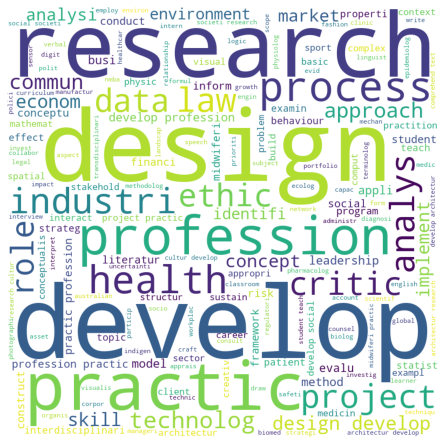

In [51]:
plt.figure(figsize = (12, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
print('='*10, 'Wordcloud obtained from all the extracted keywords', '='*10, '\n')
plt.show()

In [64]:
departments = df['Department']

In [81]:
keywords_groupedby_dep = {}
for dep in departments.dropna().unique():
    keywords_groupedby_dep[dep] = ''

In [83]:
for i in range(len(keywords)):
    if departments[i] is not None:
        for word in keywords[i]:
            keywords_groupedby_dep[departments[i]] += word + ' '

==================== Wordcloud obtained separately from extracted keywords of each department ==================== 



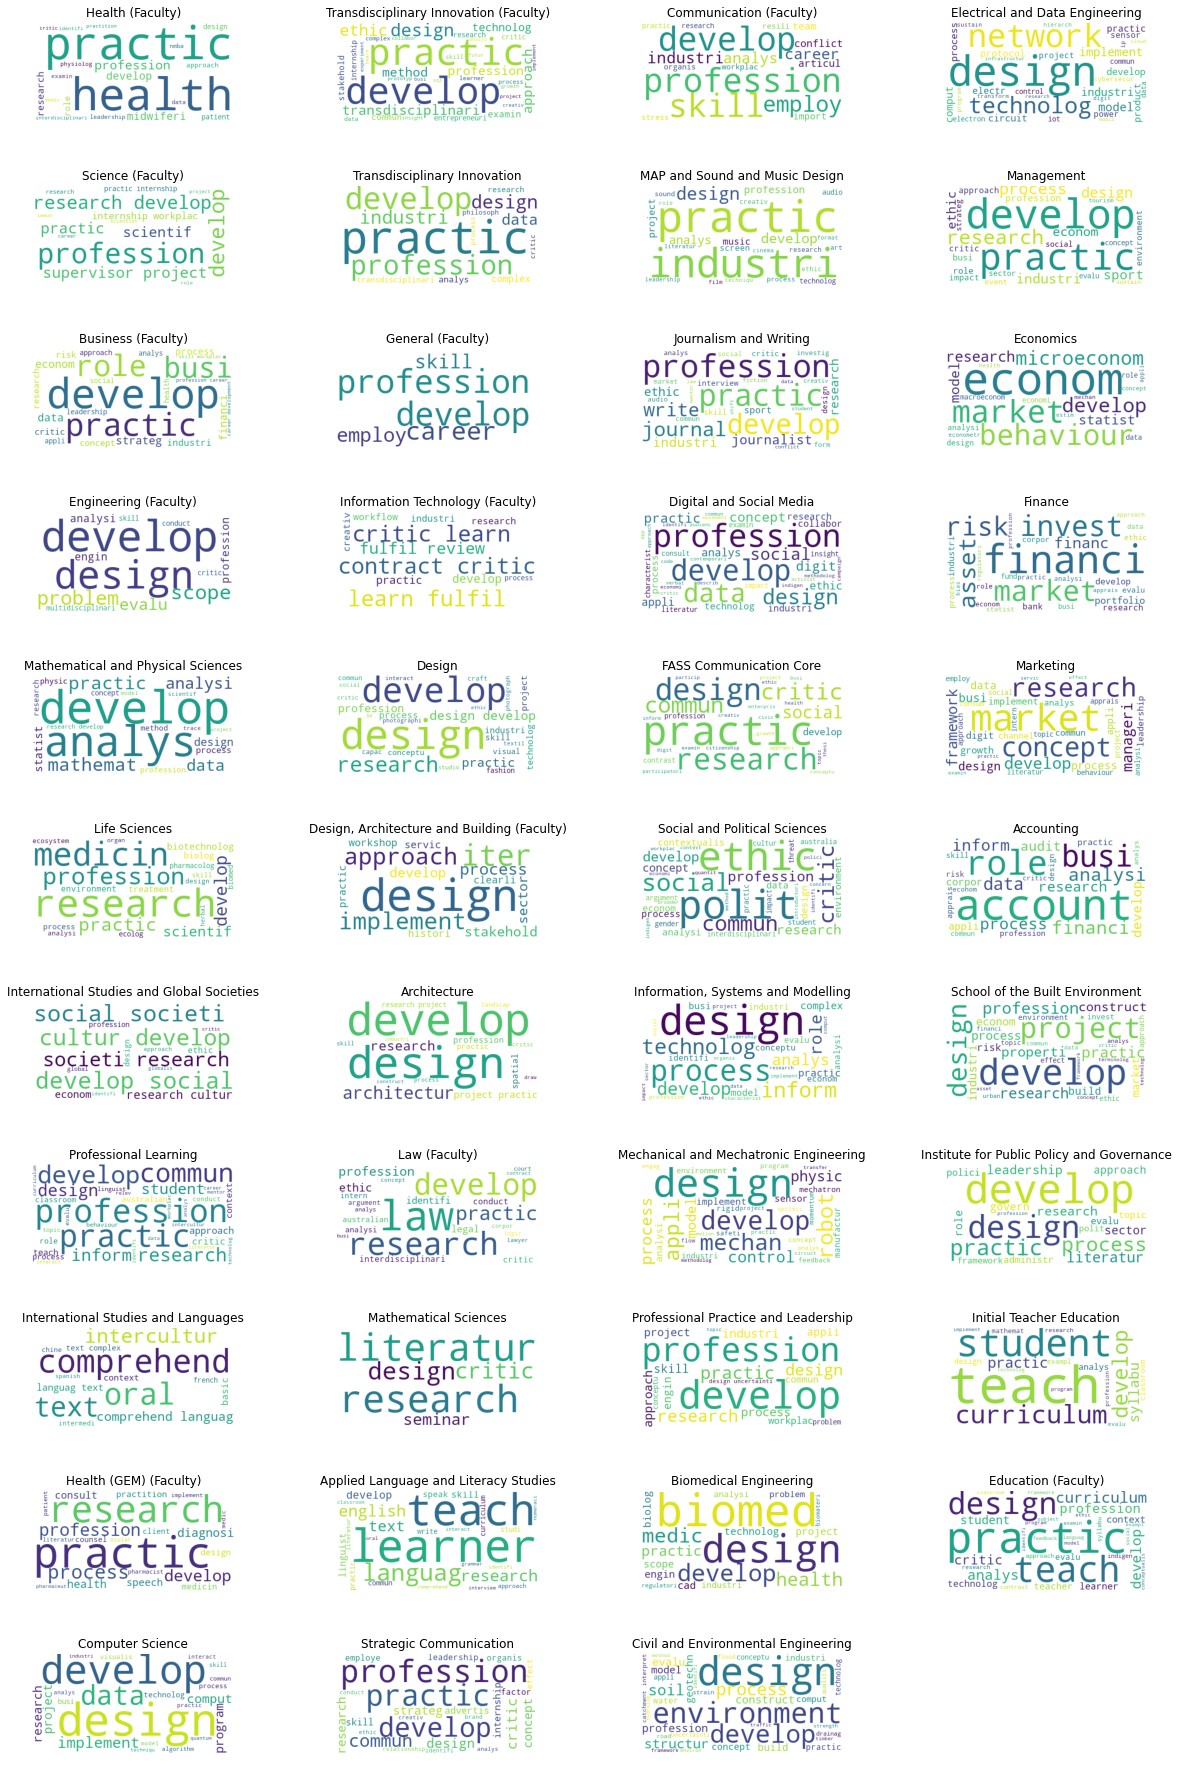

In [109]:
print('='*20, 'Wordcloud obtained separately from extracted keywords of each department', '='*20, '\n')

plt.rcParams['figure.figsize'] = (20,32)
fig, axes = plt.subplots(nrows=11, ncols=4)
fig.subplots_adjust(hspace=0.5, wspace=0.5)

key_indx = 0
for col in range(4):
    for row in range(11):
        axes[row][col].axis("off")
        if key_indx >= len(list(keywords_groupedby_dep.keys())):
            continue

        key_ = list(keywords_groupedby_dep.keys())[key_indx]
        while len(keywords_groupedby_dep[key_]) == 0 and key_indx < len(list(keywords_groupedby_dep.keys())):
            key_indx += 1
            key_ = list(keywords_groupedby_dep.keys())[key_indx]
        
        if key_indx >= len(list(keywords_groupedby_dep.keys())):
            continue
            
        wordcloud = WordCloud(background_color ='white', min_font_size = 10).generate(keywords_groupedby_dep[key_])
        axes[row][col].imshow(wordcloud)
        axes[row][col].set_title(key_)

        key_indx += 1
        
    

plt.show()